   Sample Size  LOOCV-Brute Time (s)  LOOCV-Efficient Time (s)  \
0           25              0.020931                  0.000997   
1           50              0.037874                  0.000996   
2           75              0.058829                  0.001003   
3          100              0.083688                  0.000997   
4          125              0.112625                  0.001992   
5          150              0.143031                  0.001995   

   LOOCV-Brute MSE  LOOCV-Efficient  
0          0.00000          0.00000  
1          0.00000          0.00000  
2          0.07360          0.07360  
3          0.03320          0.03320  
4          0.02336          0.02336  
5          0.03200          0.03200  


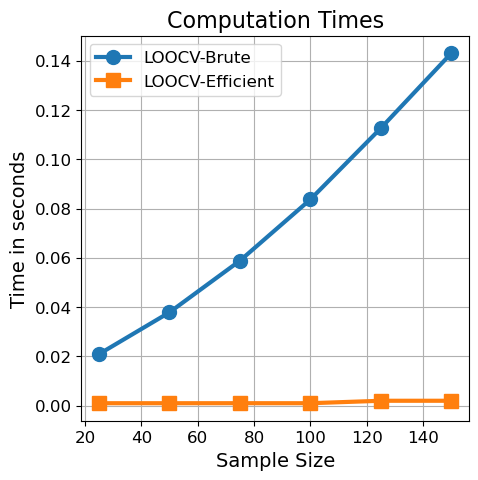

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

# Load wine dataset
data = load_wine()
X_full = data.data  # Use all features
y_full = data.target

# Standardize the features
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

# Define fixed k
fixed_k = 5

# Sample sizes to test
sample_sizes = [25, 50, 75, 100, 125, 150]
results = []

for n in sample_sizes:
    # Use only the first n samples
    X_scaled = X_full_scaled[:n, :]
    y = y_full[:n]

    # Time LOOCV-Brute
    start_time_loocv = time.time()
    loo_scores = []
    for i in range(n):
        X_train = np.concatenate((X_scaled[:i], X_scaled[i+1:]))
        y_train = np.concatenate((y[:i], y[i+1:]))
        X_test = X_scaled[i:i+1]
        y_test = y[i:i+1]
        regressor = KNeighborsRegressor(n_neighbors=fixed_k, algorithm='kd_tree')
        regressor.fit(X_train, y_train)
        se = (y_test - regressor.predict(X_test)) ** 2
        loo_scores.append(se.item())
    mse_loocv = np.mean(loo_scores)
    end_time_loocv = time.time()
    loocv_time = end_time_loocv - start_time_loocv

    # Time LOOCV-Efficient
    start_time_adj = time.time()
    regressor_k_plus_1 = KNeighborsRegressor(n_neighbors=fixed_k + 1, algorithm='kd_tree')
    regressor_k_plus_1.fit(X_scaled, y)
    y_pred_k_plus_1 = regressor_k_plus_1.predict(X_scaled)
    mse_k_plus_1 = (y - y_pred_k_plus_1) ** 2
    adjusted_score = np.mean(mse_k_plus_1) * ((fixed_k + 1) ** 2 / fixed_k ** 2)
    end_time_adj = time.time()
    adj_time = end_time_adj - start_time_adj

    # Store results
    results.append({
        'Sample Size': n,
        'LOOCV-Brute Time (s)': loocv_time,
        'LOOCV-Efficient Time (s)': adj_time,
        'LOOCV-Brute MSE': mse_loocv,
        'LOOCV-Efficient': adjusted_score
    })

# Create DataFrame for the results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

# Plotting the computation times
plt.figure(figsize=(5, 5))
plt.plot(results_df['Sample Size'], results_df['LOOCV-Brute Time (s)'], label='LOOCV-Brute', marker='o', markersize=10, linewidth=3)
plt.plot(results_df['Sample Size'], results_df['LOOCV-Efficient Time (s)'], label='LOOCV-Efficient', marker='s', markersize=10, linewidth=3)
plt.title('Computation Times', fontsize=16)
plt.xlabel('Sample Size', fontsize=14)
plt.ylabel('Time in seconds', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
# Setting the tick label sizes
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()
